# Galaxy vs Quasars

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors))


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.naive_bayes import GaussianNB

from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

- First, read the datafile.
- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

In [2]:
data = pd.read_csv('galaxyquasar.csv')
print(data)
data_arr = np.array(data)

u = np.array(data_arr[:,0])
g = np.array(data_arr[:, 1])
r = np.array(data_arr[:, 2])
i = np.array(data_arr[:, 3])
z = np.array(data_arr[:, 4])
class_ = np.array(data_arr[:, 5]) #array for column class
    

              u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3  

In [3]:
#galaxy = 0, quasar = 1

labels = np.where(class_ =="QSO", 1, 0)
print(labels)

#(u-g) color
ug = np.array(u-g)
#(g-r) color
gr = np.array(g-r)
#(r-i) color
ri = np.array(r-i)
#(i-z) color
iz = np.array(i-z)

[1 0 0 ... 0 0 0]


## Classify the dataset against the target label

- Classify the dataset against the target label.

We split the dataset and plot the results.

In [4]:
colors = ['ug', 'gr', 'ri', 'iz']

#split the dataset
x = np.array([ug, gr, ri, iz]).T

xtrain, xtest, ytrain, ytest = train_test_split(x, labels, test_size=0.5, random_state=1)

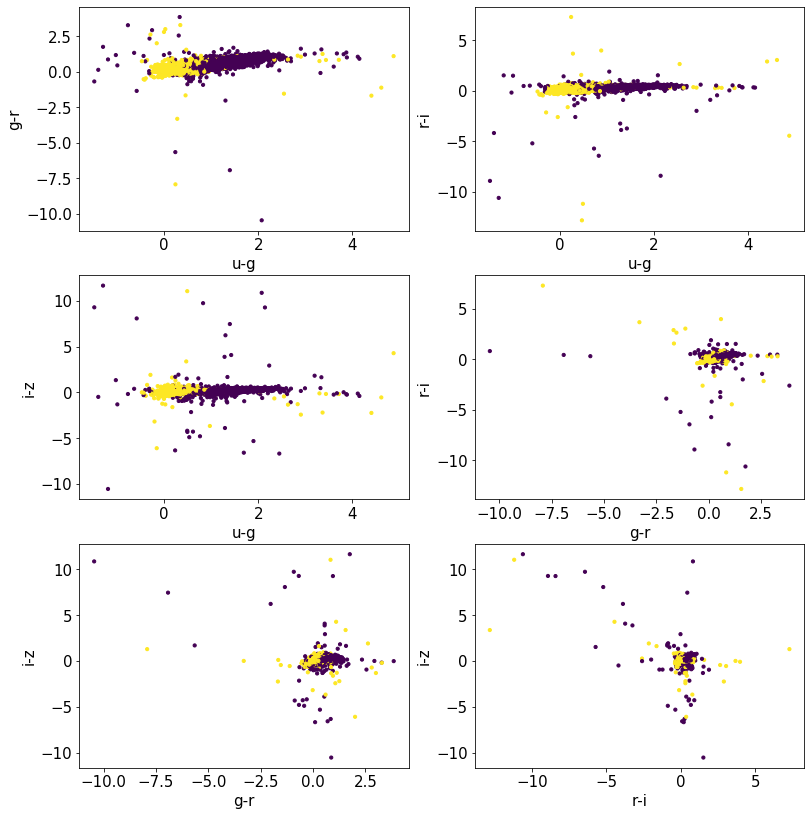

In [5]:
#we plot the split datasets

fig = plt.figure(figsize=(13,14))

ax = fig.add_subplot(321)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, s=10)
plt.xlabel('u-g')
plt.ylabel('g-r')

ax = fig.add_subplot(322)
plt.scatter(xtrain[:, 0], xtrain[:, 2], c=ytrain, s=10)
plt.xlabel('u-g')
plt.ylabel('r-i')

ax = fig.add_subplot(323)
plt.scatter(xtrain[:, 0], xtrain[:, 3], c=ytrain, s=10)
plt.xlabel('u-g')
plt.ylabel('i-z')

ax = fig.add_subplot(324)
plt.scatter(xtrain[:, 1], xtrain[:, 2], c=ytrain, s=10)
plt.xlabel('g-r')
plt.ylabel('r-i')

ax = fig.add_subplot(325)
plt.scatter(xtrain[:, 1], xtrain[:, 3], c=ytrain, s=10)
plt.xlabel('g-r')
plt.ylabel('i-z')

ax = fig.add_subplot(326)
plt.scatter(xtrain[:, 2], xtrain[:, 3], c=ytrain, s=10)
plt.xlabel('r-i')
plt.ylabel('i-z')

plt.show()

Now we plot the distributions of galaxies and quasars vs the colors.

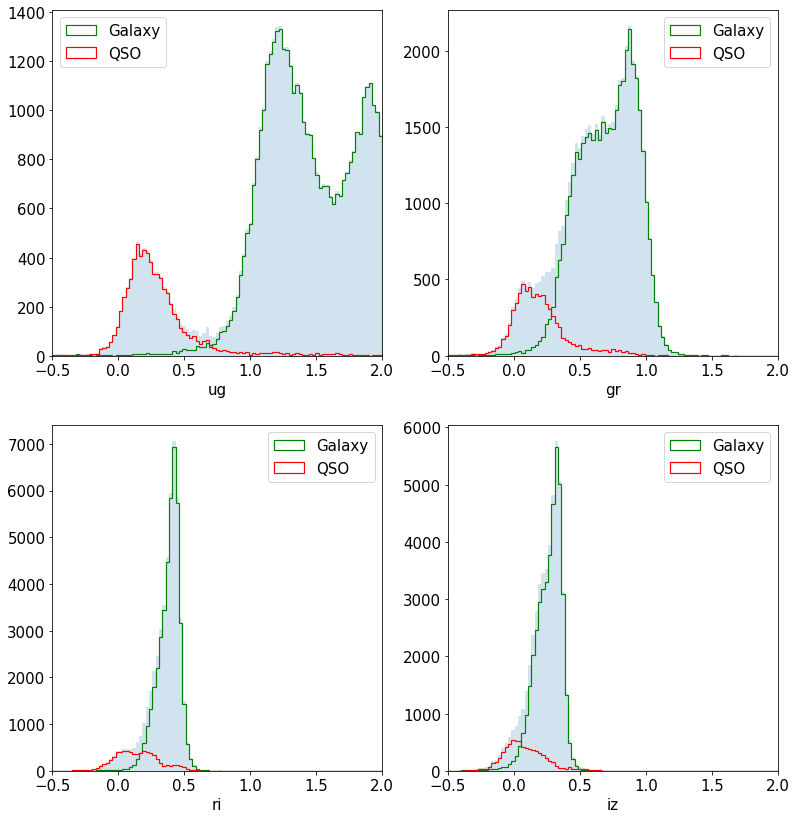

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(13, 14))
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
bins = np.linspace(-0.5, 2, 100)

for a, i in zip(axs, range(len(x))):
    a.hist(x[:, i], bins=bins, alpha=0.2)
    a.hist(x[:, i][labels==0], bins=bins, histtype='step', color='green', lw=1.2, label='Galaxy')
    a.hist(x[:, i][labels==1], bins=bins, histtype='step', color='red', lw=1.2, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-0.5, 2)
    a.legend()
plt.show()

- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

In [11]:
#cross-validation definition of errors
def rms_error(x, y, classif):
    return np.sqrt(np.sum((y - classif.predict(x))**2))/len(y)

def errors_cv(x, y, classif):
    classif.fit(xtrain, ytrain)
    error_train = rms_error(xtrain, ytrain)
    error_validation = rms_error(xtest, ytest, classif)
    return error_train, error_validation

Now we try some classification methods and then for each we evaluate the performance using ROC curve.

## Gaussian Naive Bayes

In [14]:
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

train_pred_gnb = gnb.predict(xtrain)
test_pred_gnb = gnb.predict(xtest)

In [20]:
#accuracy
accuracy_train_gnb = accuracy_score(ytrain, train_pred_gnb)
accuracy_test_gnb = accuracy_score(ytest, test_pred_gnb)

print('The accuracy of the training set is:', accuracy_train_gnb)
print('The accuracy of the test set is:', accuracy_test_gnb)

#confusion matrix
confusion_train_gnb = confusion_matrix(ytrain, train_pred_gnb)
confusion_test_gnb = confusion_matrix(ytest, test_pred_gnb)

print('\nThe confusion matrix of the training set is:\n', confusion_train_gnb)
print('\nThe confusion matrix of the test set is:\n', confusion_test_gnb)

completeness_gnb, contamination_gnb = completeness_contamination(test_pred_gnb, ytest)
print('The completeness is:', completeness_gnb)
print('The contamination is:', contamination_gnb)

The accuracy of the training set is: 0.97272
The accuracy of the test set is: 0.97388

The confusion matrix of the training set is:
 [[21058   379]
 [  303  3260]]

The confusion matrix of the test set is:
 [[21039   390]
 [  263  3308]]
The completeness is: 0.9263511621394568
The contamination is: 0.10546241211465657


In [ ]:
fig, ax = plt.figure(figuresize=(13, 14))

